In [1]:
%%capture
import warnings
import math
import pickle
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
import matplotlib.pyplot as plt
from datetime import date, datetime
from tqdm.notebook import tqdm
import re
warnings.filterwarnings('ignore')
try:
    %load_ext autotime
    %load_ext jupyterlab_notify
except:
    !pip3 install ipython-autotime
    %load_ext autotime


time: 1.19 s (started: 2023-02-19 15:25:56 -05:00)


In [2]:
df = pd.read_csv('modern_matches2.csv')
# df = df[['home_ml', 'away_ml', 'over', 'under',
#         'spread', 'home_spread', 'home_ps_odds', 'away_spread', 'away_ps_odds', 
#         'movl', 'h_win', 'playoff_game', 'past_3_home_favorite_wins', 
#          'past_3_away_favorite_wins', 'season', 'home_implied']]
df['vig'] = 1/df['home_ml'] + 1/df['away_ml'] 
df = df.drop(['favorite_won'],axis=1)
df=df.dropna(subset=['home_ml','away_ml'])

time: 389 ms (started: 2023-02-19 15:25:57 -05:00)


In [3]:
from collections import defaultdict

favorite_df = defaultdict(list)
p = re.compile('prev.*ema')

features = ['season', 'home_implied', 
            'home_win', 'home_ml', 'away_ml',
            #'prev_home_elo', 'prev_away_elo',
            #'spread', 'home_spread',
            'past_5_home_win_ratio', 'past_5_away_win_ratio',
            ] 
columns = df.columns

ema_features = [c for c in columns if p.match(c)]

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    # home team is the favorite
    
    favorite_won = False
    
    if row['home_ml'] < row['away_ml']:
        favorite_df['favorite_ml'].append(row['home_ml'])
        favorite_df['underdog_ml'].append(row['away_ml'])
        favorite_df['favorite_is_home'].append(1)
        favorite_df['recent_favorite_win_ratio_5'].append(row['past_5_home_win_ratio'])
        favorite_df['recent_underdog_win_ratio_5'].append(row['past_5_away_win_ratio'])  
        favorite_df['recent_favorite_win_ratio_4'].append(row['past_4_home_win_ratio'])
        favorite_df['recent_underdog_win_ratio_4'].append(row['past_4_away_win_ratio'])           
        favorite_df['recent_favorite_win_ratio_3'].append(row['past_3_home_win_ratio'])
        favorite_df['recent_underdog_win_ratio_3'].append(row['past_3_away_win_ratio'])
        if row['home_win']:
            favorite_won = True
    else:
        if not row['home_win']:
            favorite_won = True
        favorite_df['favorite_ml'].append(row['away_ml'])
        favorite_df['underdog_ml'].append(row['home_ml'])

        favorite_df['favorite_is_home'].append(0)
        favorite_df['recent_favorite_win_ratio_5'].append(row['past_5_away_win_ratio']) 
        favorite_df['recent_underdog_win_ratio_5'].append(row['past_5_home_win_ratio'])
        favorite_df['recent_favorite_win_ratio_4'].append(row['past_4_away_win_ratio']) 
        favorite_df['recent_underdog_win_ratio_4'].append(row['past_4_home_win_ratio'])
        favorite_df['recent_favorite_win_ratio_3'].append(row['past_3_away_win_ratio']) 
        favorite_df['recent_underdog_win_ratio_3'].append(row['past_3_home_win_ratio'])

    favorite_df['favorite_won'].append(1 if favorite_won else 0)
    favorite_df['point_spread'].append(abs(row['home_spread']))


favorite_df = pd.DataFrame(favorite_df)
favorite_df = pd.concat([df.reset_index(drop=True),
                      favorite_df.reset_index(drop=True)],axis=1)
favorite_df['vig'] = 1/favorite_df['favorite_ml'] + 1/favorite_df['underdog_ml'] - 1
favorite_df['favorite_implied'] = 1/favorite_df['favorite_ml'] - favorite_df['vig']/2
favorite_df['underdog_implied'] = 1/favorite_df['underdog_ml'] - favorite_df['vig']/2

favorite_df.to_csv('processed_nba_data.csv', header=True, index=False)
print(favorite_df[['favorite_ml', 'home_ml', 'away_ml']])

  0%|          | 0/11513 [00:00<?, ?it/s]

       favorite_ml   home_ml    away_ml
0         1.099266  1.099266   8.100000
1         1.456783  1.456783   2.830000
2         1.171482  5.400000   1.171482
3         1.103647  1.103647   7.890000
4         1.058775  1.058775  11.460000
...            ...       ...        ...
11508     1.495142  1.495142   2.727778
11509     1.658921  1.658921   2.338000
11510     1.638972  1.638972   2.367059
11511     1.605194  1.605194   2.437778
11512     1.574627  1.574627   2.521111

[11513 rows x 3 columns]
time: 3 s (started: 2023-02-19 15:25:57 -05:00)


n_favorites that won 7830
favorite win ratio 0.6801007556675063


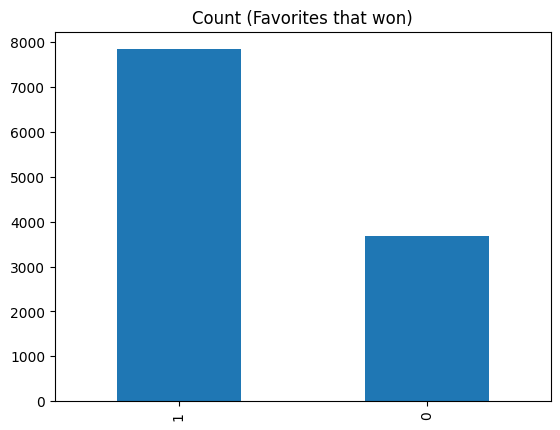

time: 117 ms (started: 2023-02-19 15:26:06 -05:00)


In [4]:
print('n_favorites that won', sum(favorite_df['favorite_won']))
print('favorite win ratio', sum(favorite_df['favorite_won'])/len(favorite_df))
favorite_df.favorite_won.value_counts().plot(kind='bar', title='Count (Favorites that won)');

In [ ]:
from sklearn.decomposition import PCA
X = favorite_df[['favorite_ml','favorite_implied', 'favorite_is_home', 
                'recent_favorite_win_ratio_3','recent_underdog_win_ratio_3',
                'spread', 'point_spread', 'favorite_won']]
X = X.dropna()
y = X['favorite_won']
pca = PCA(n_components=2)
X = pca.fit_transform(X)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from collections import Counter


rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X, y)
print('Original dataset shape %s' % Counter(y))
print('Resampled dataset shape %s' % Counter(y_rus))


# Model 1: Log Reg

In [245]:
import pandas as pd
import numpy as np
import pickle

import warnings
import sys
import re
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression 
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
from sklearn.metrics import confusion_matrix, f1_score
import imblearn

def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

def train_test_split(data):
    cutoff = math.floor(len(data) * 0.8)
    data = data.dropna()

    train = data[data.index < cutoff].copy()
    test = data[data.index >= cutoff].copy()
    # train = data[data.season < 2020].copy()
    # test = data[data.season >= 2020].copy()
    rus = RandomUnderSampler(random_state=42)
    print('Original dataset shape %s' % Counter(train['favorite_won']))
    # train_x, train_y = rus.fit_resample(train, train_y)
    favorite_winners = train[train.favorite_won == 1].index
    sample_size = len(train[train.favorite_won == 0])
    favorite_winners = train[train.favorite_won == 1].index
    underdog_winners = train[train.favorite_won == 0].index

    np.random.seed(42)
    favorite_winners_indices = np.random.choice(favorite_winners, sample_size, replace=False)
    underdog_winners_indices = np.random.choice(underdog_winners, sample_size, replace=False)
    
    
    print(favorite_winners_indices[:5])
    print(underdog_winners_indices[:5])
    all_indices = np.concatenate((favorite_winners_indices,
                                 underdog_winners_indices),
                                 axis=0)
    print(all_indices)
    all_indices = np.sort(all_indices)
    train = train.loc[all_indices]

    print('Resampled dataset shape %s' % Counter(train['favorite_won']))
    return train, test

time: 1.67 ms (started: 2023-02-19 17:06:50 -05:00)


In [246]:
data = pd.read_csv('processed_nba_data.csv')
features = ['favorite_implied', 
            'favorite_won', 'favorite_ml', 'underdog_ml',
            'spread', 'point_spread',
            'recent_favorite_win_ratio_4', 'recent_underdog_win_ratio_4',
            'favorite_is_home'
            ] 
data = data[features]
data.dropna(inplace=True)

time: 460 ms (started: 2023-02-19 17:06:50 -05:00)


In [247]:
# Undersample to reduce favorite win ratio in training data
train, test = train_test_split(data)
   
train_y = train['favorite_won']
test_y = test['favorite_won']
train_x = train.drop(["favorite_won", 'favorite_ml', 'underdog_ml'], axis=1)
test_x = test.drop(["favorite_won", 'favorite_ml', 'underdog_ml'], axis=1)

scaler = preprocessing.StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)


Original dataset shape Counter({1: 6197, 0: 2898})
[7406 7044 1807 7627 3419]
[2884 7017 6804 1942 7192]
[7406 7044 1807 ... 4767 5959 1607]
Resampled dataset shape Counter({0: 2898, 1: 2898})
time: 7.77 ms (started: 2023-02-19 17:06:51 -05:00)


In [248]:
# Undersample to reduce favorite win ratio in training data
train, test = train_test_split(data)
   
train_y = train['favorite_won']
test_y = test['favorite_won']
train_x = train.drop(["favorite_won", 'favorite_ml', 'underdog_ml'], axis=1)
test_x = test.drop(["favorite_won", 'favorite_ml', 'underdog_ml'], axis=1)

scaler = preprocessing.StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.fit_transform(test_x)


Original dataset shape Counter({1: 6197, 0: 2898})
[7406 7044 1807 7627 3419]
[2884 7017 6804 1942 7192]
[7406 7044 1807 ... 4767 5959 1607]
Resampled dataset shape Counter({0: 2898, 1: 2898})
time: 7.86 ms (started: 2023-02-19 17:06:51 -05:00)


In [249]:
print(train['favorite_won'])

61      0
65      0
66      0
68      0
69      0
       ..
9154    1
9155    1
9156    0
9157    1
9158    0
Name: favorite_won, Length: 5796, dtype: int64
time: 1.65 ms (started: 2023-02-19 17:06:51 -05:00)


In [250]:
print('n_favorites that won', sum(train_y))
print('favorite win ratio', sum(train_y)/len(train_y))

n_favorites that won 2898
favorite win ratio 0.5
time: 937 µs (started: 2023-02-19 17:06:52 -05:00)


In [251]:
# alpha = float(sys.argv[1]) if len(sys.argv) > 1 else 0.5
# l1_ratio = float(sys.argv[2]) if len(sys.argv) > 2 else 0.5
lr = LogisticRegression(random_state=42)
lr.fit(train_x, train_y)

predictions = lr.predict_proba(test_x)
predictions = [i[1] for i in predictions]

predictions = pd.Series(predictions, name='lr_favorite_prob')
pred_df = pd.concat([test_y.reset_index(drop=True), 
                predictions.reset_index(drop=True)], 
            axis=1)
pred_df['lr_pred_favorite'] = pred_df['lr_favorite_prob'].map(lambda x: 0 if x < 0.4 else 1)
pred_df['correct_pred'] = pred_df.apply(lambda x: 
    1 if x['favorite_won'] == x['lr_pred_favorite'] else 0, axis = 1)
acc = pred_df['correct_pred'].sum()/len(pred_df.index)
pred_df.to_csv('lr_predictions.csv', header=True, index=False)
print(f'Accuracy: {acc}')

confusion_mat = confusion_matrix(pred_df['favorite_won'], pred_df['lr_pred_favorite'])
print(confusion_mat)
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
f1 = f1_score(pred_df['favorite_won'], pred_df['lr_pred_favorite'])
print(f'F1 Score: {f1}')

print(pred_df.head())

importance =lr.coef_[0]

filename = 'lr_model.sav'
pickle.dump(lr, open(filename, 'wb'))

Accuracy: 0.6363636363636364
[[ 316  447]
 [ 409 1182]]
F1 Score: 0.7341614906832299
   favorite_won  lr_favorite_prob  lr_pred_favorite  correct_pred
0             0          0.385127                 0             1
1             1          0.520906                 1             1
2             1          0.637136                 1             1
3             0          0.610700                 1             0
4             1          0.427504                 1             1
time: 58.5 ms (started: 2023-02-19 17:06:53 -05:00)


In [264]:
# save meta labels

all_useable_data = pd.concat([train,test])
features = ['favorite_implied', 
            'spread', 'point_spread',
            'recent_favorite_win_ratio_4', 'recent_underdog_win_ratio_4',
            'favorite_is_home'
            ] 
#print(all_useable_data)
all_x = all_useable_data[features]
all_y = all_useable_data['favorite_won']
scaler = preprocessing.StandardScaler()
all_x = scaler.fit_transform(all_x)
predictions = lr.predict_proba(all_x)
predictions = [i[1] for i in predictions]


predictions = pd.Series(predictions, name='lr_favorite_prob')
all_x = pd.DataFrame(all_x, columns = features)

pred_df = pd.concat([predictions.reset_index(drop=True),
                     all_x.reset_index(drop=True),
            all_useable_data[['favorite_ml', 'underdog_ml', 'favorite_won']].reset_index(drop=True)], 
            axis=1)
pred_df['lr_pred_favorite'] = pred_df['lr_favorite_prob'].map(lambda x: 0 if x < 0.45 else 1)
pred_df['correct_pred'] = pred_df.apply(lambda x: 
    1 if x['favorite_won'] == x['lr_pred_favorite'] else 0, axis = 1)
acc = pred_df['correct_pred'].sum()/len(pred_df.index)
pred_df.to_csv('all_lr_predictions.csv', header=True, index=False)
print(sum(pred_df['lr_pred_favorite']))
print(len(pred_df['lr_pred_favorite']))

print('classes: ', lr.classes_)

4659
8150
classes:  [0 1]
time: 125 ms (started: 2023-02-19 17:12:42 -05:00)


In [263]:
len(train_x)

5796

time: 1.13 ms (started: 2023-02-19 17:12:31 -05:00)


# Model 2: LR with meta labels

In [291]:
data = pd.read_csv('all_lr_predictions.csv')
data['bookie_pred'] = data.apply(lambda x: 1 if x['favorite_ml'] < x['underdog_ml'] else 0, axis=1)
features = ['favorite_won', 'favorite_ml', 'underdog_ml',
            'spread', 'point_spread',
            'recent_favorite_win_ratio_4', 'recent_underdog_win_ratio_4',
            'favorite_is_home','bookie_pred']
data = data[features]
train = data[data.index < 5796].copy()
test = data[data.index >= 5796].copy()
train_x = train.drop(["favorite_won", 'favorite_ml', 'underdog_ml',], axis=1)
test_x = test.drop(["favorite_won", 'favorite_ml', 'underdog_ml'], axis=1)
train_y = train[["favorite_won"]]
test_y = test[["favorite_won"]]

time: 42.1 ms (started: 2023-02-19 17:58:07 -05:00)


In [305]:
secondary_lr = LogisticRegression(random_state=42)
secondary_lr.fit(train_x, train_y)

predictions = secondary_lr.predict_proba(test_x)
predictions = [i[1] for i in predictions]

predictions = pd.Series(predictions, name='secondary_winning_prob')
pred_df = pd.concat([test_y.reset_index(drop=True),
                     test['bookie_pred'].reset_index(drop=True),
                    predictions.reset_index(drop=True),
                    # test['favorite_implied'].reset_index(drop=True),
                    test['favorite_ml'].reset_index(drop=True),
                    test['underdog_ml'].reset_index(drop=True)], 
                    axis=1)

pred_df['secondary_pred_favorite'] = pred_df['secondary_winning_prob'].map(lambda x: 0 if x < 0.4 else 1)

pred_df['final_pred'] = pred_df.apply \
    (lambda x: 1 if x['bookie_pred'] == 1 and x['secondary_pred_favorite'] == 1 \
     else 0, axis=1)
   

pred_df['final_correct_pred'] = pred_df.apply(lambda x: 
    1 if x['favorite_won'] == x['final_pred'] else 0, axis = 1)
pred_df['bookie_correct_pred'] = pred_df.apply(lambda x: 
    1 if x['favorite_won'] == x['bookie_pred'] else 0, axis = 1)
acc = pred_df['final_correct_pred'].sum()/len(pred_df.index)
bookie_acc = pred_df['bookie_correct_pred'].sum()/len(pred_df.index)

pred_df.to_csv('secondary_lr_predictions.csv', header=True, index=False)
print(f'LR Accuracy: {acc}')

confusion_mat = confusion_matrix(pred_df['favorite_won'], pred_df['final_pred'])
print(confusion_mat)
print(f'Bookie Accuracy: {bookie_acc}')
confusion_mat = confusion_matrix(pred_df['favorite_won'], pred_df['bookie_pred'])
print(confusion_mat)
f1 = f1_score(pred_df['favorite_won'], pred_df['final_pred'])
print(f'F1 Score: {f1}')

print(pred_df[['bookie_pred', 
               'secondary_winning_prob', 
               'secondary_pred_favorite',
               'final_pred',
               'favorite_won',
               'final_correct_pred']])  
filename = 'secondary_lr_model.sav'
pickle.dump(secondary_lr, open(filename, 'wb'))

LR Accuracy: 0.6338147833474936
[[ 339  424]
 [ 438 1153]]
Bookie Accuracy: 0.6758708581138487
[[   0  763]
 [   0 1591]]
F1 Score: 0.7279040404040404
      bookie_pred  secondary_winning_prob  secondary_pred_favorite  \
0               1                0.386414                        0   
1               1                0.508249                        1   
2               1                0.618643                        1   
3               1                0.595155                        1   
4               1                0.418966                        1   
...           ...                     ...                      ...   
2349            1                0.464127                        1   
2350            1                0.432089                        1   
2351            1                0.414800                        1   
2352            1                0.411213                        1   
2353            1                0.468260                        1   

      fi

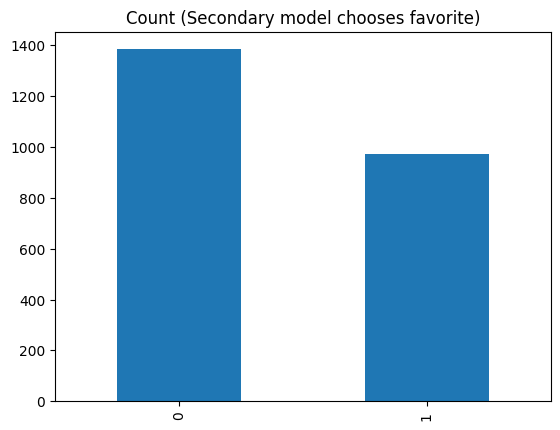

time: 87.1 ms (started: 2023-02-19 17:16:35 -05:00)


In [268]:
pred_df.secondary_pred_favorite.value_counts()\
    .plot(kind='bar', title='Count (Secondary model chooses favorite)');

In [45]:
#summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print(test.columns)
print(test.favorite_implied)

Feature: 0, Score: 0.09517
Feature: 1, Score: -0.04432
Feature: 2, Score: 0.54377
Feature: 3, Score: -0.05331
Feature: 4, Score: 0.02954
Feature: 5, Score: -0.03712
Index(['favorite_implied', 'favorite_won', 'favorite_ml', 'underdog_ml',
       'spread', 'point_spread', 'recent_favorite_win_ratio_5',
       'recent_underdog_win_ratio_5', 'favorite_is_home'],
      dtype='object')
8577     0.734102
8578     0.541123
8579     0.870674
8580     0.893217
8581     0.521868
           ...   
11508    0.651117
11509    0.587543
11510    0.593837
11511    0.606384
11512    0.619210
Name: favorite_implied, Length: 2936, dtype: float64
time: 1.45 ms (started: 2023-02-19 15:42:03 -05:00)


In [ ]:
pred_df['secondary_winning_prob'].plot()

In [ ]:
print(f'n_bet_favorite:', sum(pred_df['final_pred']))
print(f'n_games:', len(pred_df))

# Backtest

In [ ]:
# assuming bet probability predictions follow a standard distribution
from statistics import NormalDist
def prob_to_bet_size(p):
    z_score = (p-1/2)/sqrt(p*(1-p))
    #'Cumulative distribution function for the standard normal distribution'
    bet_size = 2*NormalDist(mu=0, sigma=1).cdf(z_score)-1
    return bet_size

In [ ]:
# bet on favorites

def bet_favorite(df):
    balance = 100
    for index, row in df.iterrows():
        bet_favorite = False
        bet_size = row['secondary_lr_
        if row['final_pred'] == 1:
        df.at[index, 'bet_won'] = 1
        df.at[index, 'profit'] = 1
        df.at[index, 'bet_amount'] = 
   
        df.at[index, 'balance'] = balance
    return balance

In [ ]:
df = pd.read_csv('secondary_lr_predictions.csv')
